# Deep Reinforcement learning

Author : Nicholas Setijabudiharsa

TSE - Econometrics and Statistics : Data science for social science

2022

## 1 Reinforcement learning

### 1.1 Definitions and  Framework

In order to better understand the idea of reinforcement learning, lets take an example of a game of chess. Theoritically speaking, one can create an brute force algorithm that analyze all possible states of the game and takes into account all the possible states that can come after the current state, and take the action that give the most probability of winning at the end. However, this method is very inefficient. In 2021, [John Tromp](https://github.com/tromp/ChessPositionRanking) did an analysis and found that there are about $4.8 x 10^{44}$ possible combinations of legal chess positions in chess. For perspective, here is the full form of that number

$$480000000000000000000000000000000000000000000$$

So for sure, this process is very inefficient. This is where Reinforcement learning comes in handy.



Reinforcement learning is the process optimizing an agent's action $a$ of a given state $s$ by optimizing it's policy $\pi(s, a)$ where
$$
\pi(s, a) = Pr(a=a | s=s)
$$

This allows us to define a notion of Value for a given state for a given policy which will be the expected discounted future rewards or in mathematical terms

$$
V_\pi(s) = E(\sum_t\gamma^t r_t |s_0=s)
$$

with $\gamma$ to be the discount rate.


With our given framework we can now understand that the goal of Reinforcement learning is a **maximization problem** where we **optimize** our agent's policy to **maximize** future rewards.

Generally we also normally assume our model is based on a markovian decision process, where we dont take the next steps with certainty but instead given a current state $s_t$, we assume that $s_{t+1}$ adopts a certain probability distribution. For example, any games that includes rolling a dice.

An environment where we get an information about the reward after every action an agent take, is called **Dense** rewards, on the other hand, environment such as playing a simple game of chess where we only receive rewards at the end of the game (whether we win or loses), is called **Sparse** rewards, naturally, the denser the rewards, the more efficient our data will be and therefore faster our learning will be.

## 2 Deep Reinforcement Learning [draft only](https://www.youtube.com/watch?v=wDVteayWWvU&ab_channel=SteveBrunton)

### 2.1 Deep policy network

Takes input state and returns policy $\pi_\theta(s, a)$ where $\theta$ is weight of our NN

### 2.2 Deep Q Network

## 3 Implementation

In [14]:
import gym
from stable_baselines import ACER
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

import copy
import torch
from torch.autograd import Variable
import random
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np

import time


In [3]:
env = gym.make("LunarLander-v2")
episodes = 2
for ep in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render("human")
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print("Episode {} Score {}".format(ep, score))
env.close()

Episode 1 Score -128.22346888941178
Episode 2 Score -95.40534570650371


In [15]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()



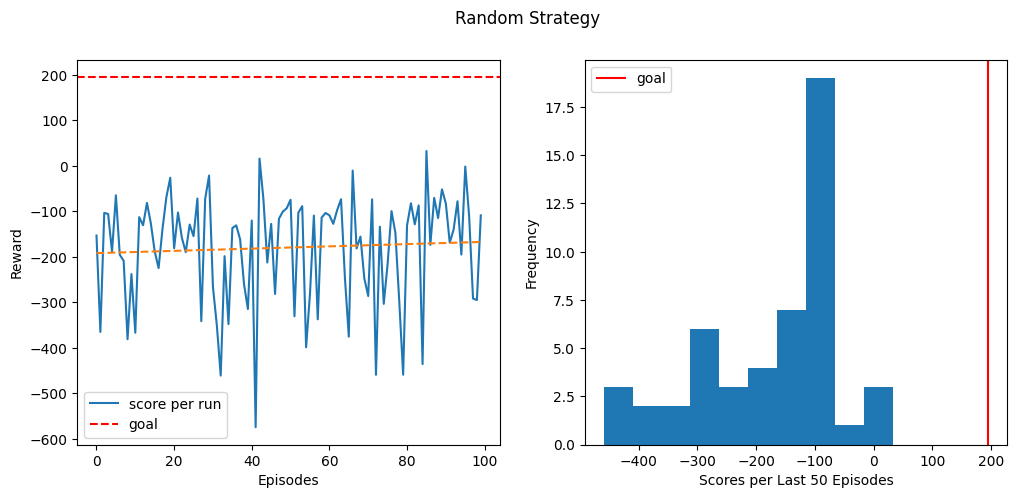

In [17]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
    plot_res(final,title)
    return final
env = gym.make("LunarLander-v2")
random_result = random_search(env, episodes=100)

In [20]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [21]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final



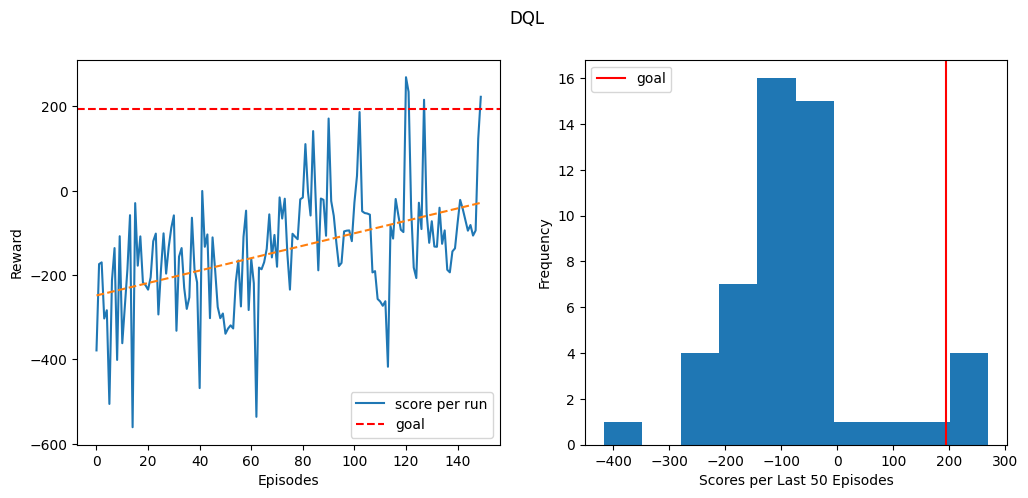

episode: 150, total reward: 222.85244034725648


In [22]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3)

### DQN Replay

In [24]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())



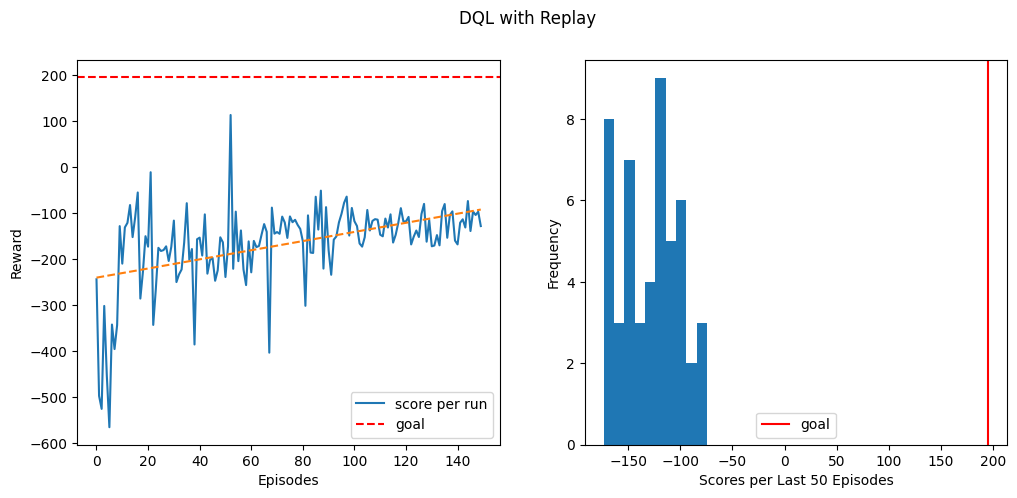

episode: 150, total reward: -128.5662702787228
Average replay time: 1.0815745878219605


In [25]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')



## DQN Double

In [26]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

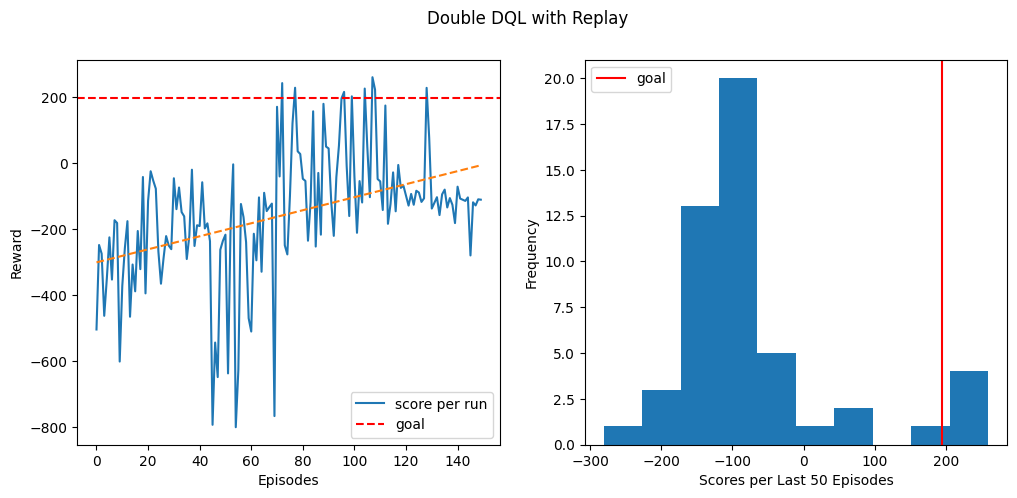

episode: 150, total reward: -111.78435400210978
Average replay time: 2.681580546696981


In [27]:
           
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)